In [1]:
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Point, Polygon, MultiPolygon
from pathlib import Path
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import pandas as pd
import pyproj
import fiona
import boto3

In [2]:
# This will find the folder path of the user so that data can be read in
directory = Path.cwd()
str_dir = str(directory)
clean_path = str_dir.replace('Tutorials', '')
print(clean_path)

C:\Users\ryane\Documents\Github\ladi-tutorial\


### The following datasets will be used in this analysis:

In [3]:
# https://catalog.data.gov/dataset/tiger-line-shapefile-2017-nation-u-s-current-state-and-equivalent-national
file = Path(str(clean_path) + '/data/Census-State/tl_2017_us_state.shp')
states = gpd.read_file(file)
# This line sets the CRS (Coordinate Reference System) so that all our maps will line up when plotting
states.crs = fiona.crs.from_epsg(4326) 

# https://ais-faa.opendata.arcgis.com/datasets/e747ab91a11045e8b3f8a3efd093d3b5_0
file = Path(str(clean_path) + '/data/FAA-Airports/Airports.shp')
airports = gpd.read_file(file)
airports.crs = fiona.crs.from_epsg(4326)

# https://catalog.data.gov/dataset/tiger-line-shapefile-2019-nation-u-s-current-metropolitan-statistical-area-micropolitan-statist
file = Path(str(clean_path) + '/data/Census-CBSA/tl_2019_us_cbsa.shp')
us_cbsa = gpd.read_file(file)
us_cbsa.crs = fiona.crs.from_epsg(4326)

# http://www2.census.gov/programs-surveys/ahs/2017/AHS%202017%20National%20PUF%20v3.0%20Flat%20CSV.zip?#
file = Path(str(clean_path) + '/data/Census-AHS/ahs2017n.csv')
ahs_data = pd.read_csv(file, usecols=['OMB13CBSA', 'DPFLDINS'])

### Functions:

In [4]:
def meters_to_degrees(distance_meters):
    
    '''https://sciencing.com/convert-distances-degrees-meters-7858322.html (111,139)'''
    
    distance_degrees = (distance_meters / 111194.926644559) # number derived from matlab calculations
    return distance_degrees

In [5]:
def df_to_gdf(df, what_on): 
    
    '''df_to_gdf merges a given DataFrame with image_metadata_gdf on whatever column name they choose'''
    
    merged_df = df.merge(image_metadata_gdf, on=what_on)
    clean_df = merged_df.dropna()
    gdf = GeoDataFrame(clean_df, crs=fiona.crs.from_epsg(4326))
    
    return gdf

In [6]:
def state_finder(df):  
    
    '''state_finder performs a spacial join with the states shapefile to find what state points are plotted in'''
    
    label_by_state = gpd.sjoin(df, states, op='within')
    label_by_state = label_by_state.drop(columns=['index_right'])
    
    return(label_by_state)

In [7]:
def get_column_values(dataset_name, dataset_column): 
    
    '''get_column_values returns a dictionary that tells us how many of each value was found for a given column in a dataset'''
    
    column_dictionary_counter = {} 
    values = dataset_name[dataset_column].tolist()
    for i in values:
        if i not in column_dictionary_counter:
            column_dictionary_counter[i] = values.count(i)
            
    return(column_dictionary_counter)

In [8]:
def months_with_images(state_abbreviation, label, year): 
    
    '''This function returns a dictionary telling the user how many photos were taken each month for the given dataset'''
    
    # Merge the images with the states to get a state name for each image
    images_by_state = state_finder(label)

    # Find images that were taken during the given timestamp
    state_images = images_by_state[images_by_state.STUSPS == state_abbreviation]
    state_images_timestamp = state_images[state_images['timestamp'].str.contains(year, na=False, case=True)]
    
    # Create a dictionary with the month names as keys and how many images were taken as their values
    months = {}
    for i in range(len(state_images_timestamp.timestamp)):
        month = pd.Timestamp(state_images_timestamp.timestamp.iloc[i])
        if month.month_name() not in months:
            state_images_per_month = 0
            
            for j in range(len(state_images_timestamp.timestamp)):
                month_counter = pd.Timestamp(state_images_timestamp.timestamp.iloc[j])
                if month.month_name() == month_counter.month_name():
                    state_images_per_month += 1
                months[month.month_name()] = state_images_per_month
    return(print(months))

In [9]:
def months_with_images(state_abbreviation, label, year): 
    
    '''This function returns a dictionary telling the user how many photos were taken each month for the given dataset'''
    
    # Merge the images with the states to get a state name for each image
    images_by_state = state_finder(label)

    # Find images that were taken during the given timestamp
    state_images = images_by_state[images_by_state.STUSPS == state_abbreviation]
    state_images_timestamp = state_images[state_images['timestamp'].str.contains(year, na=False, case=True)]
    
    # Create a dictionary with the month names as keys and how many images were taken as their values
    months = {}
    for i in range(len(state_images_timestamp.timestamp)):
        month = pd.Timestamp(state_images_timestamp.timestamp.iloc[i])
        if month.month_name() not in months:
            state_images_per_month = 0
            
            for j in range(len(state_images_timestamp.timestamp)):
                month_counter = pd.Timestamp(state_images_timestamp.timestamp.iloc[j])
                if month.month_name() == month_counter.month_name():
                    state_images_per_month += 1
                months[month.month_name()] = state_images_per_month
    return(print(months))

In [10]:
def images_per_cbsa(gdf, cbsa): 
    
    '''images_per_cbsa tells us how many points from your GeoDataFrame were found within each cbsa code'''
    
    image_counter = {}
    
    # Perform a spacial join between cbsa codes and the given GeoDataFrame
    images_within_cbsa = gpd.sjoin(gdf, cbsa, how='left', op='within')
    images = images_within_cbsa.NAMELSAD.tolist()

    # Create a dictionary with the CBSA code names as keys and how many images were taken as their values
    for i in images:
        if i not in image_counter:
            image_counter[i] = images.count(i)
    
    # make the dictionary into a dataframe 
    image_counter = pd.DataFrame.from_dict(image_counter, orient='index')
    
    
    return image_counter

### Here we read in the image metadata from the LADI s3 bucket. We will use this data along with our human and machine labels to make a geospatial analysis of the destruction from Hurricanes Michael and Florence.

In [11]:
bucket_name = 'ladi'
file_1_path = 'Labels/ladi_images_metadata.csv'
client = boto3.client('s3')

obj_1 = client.get_object(Bucket = bucket_name, Key = file_1_path)

image_metadata = pd.read_csv(obj_1['Body'])
image_metadata_renamed = image_metadata.rename(columns={"uuid": "image_uuid"})
image_metadata_clean = image_metadata_renamed.dropna()

latitude = image_metadata_clean['gps_lat'].tolist() 
longitude = image_metadata_clean['gps_lon'].tolist()

#This line converts the DF to a GDF and sets the proper crs
image_metadata_gdf = GeoDataFrame(image_metadata_clean, crs=fiona.crs.from_epsg(4326), geometry=gpd.points_from_xy(longitude, latitude))


In [12]:
image_metadata_gdf

image_uuid            timestamp  \
0       a13fb353cca1f5e8060f95c80deb0c49e9a21f91  2016-01-16 07:34:55   
1       03e5da2bc5e32cd7d58a164eefce499e2f14e06f  2014-06-24 13:09:20   
4       1c702459e21e5a7e7fec5eefaab42f5e5124113a  2014-06-24 11:21:07   
11      12b30b81f509e96c71e69ed14acdd5f7617a51b8  2015-10-06 10:06:54   
12      f148c807aac245a66b11cdb925efa22ab5d5a4da  2015-10-06 10:07:00   
...                                          ...                  ...   
580746  95fabbdbbb494beab517b5fea25a4e430d8fbcef  2020-01-27 12:01:31   
580747  4b590e5634dae396db6c838844d7670e5ef9e7f6  2020-01-27 12:00:25   
580748  bb7f86f1e9ab1a1ab3ea9e13cda998ab6e1bbb6d  2020-01-27 12:02:25   
580749  c9e5c19cb7cccf181d11b707f1a47b80341710b6  2020-01-27 12:00:45   
580750  a52da08206e51e3cd3b2cd0b42a3bb7e9623e92c  2020-01-27 12:00:39   

          gps_lat    gps_lon  gps_alt  file_size   width  height  \
0       29.623744 -95.652153     26.0  3497125.0  4608.0  3456.0   
1       32.386939 -86.344467    489.0  3518243.0  4608.0  3456.0   
4       32.371777 -86.345887    459.0  8385536.0  6000.0  4000.0   
11      33.698817 -80.510262    465.0  1768628.0  3216.0  2136.0   
12      33.701598 -80.511637    446.0  1782215.0  3216.0  2136.0   
...           ...        ...      ...        ...     ...     ...   
580746  18.002950 -66.896370    101.8  3413576.0  4000.0  3000.0   
580747  18.003440 -66.896118    101.8  3307879.0  4000.0  3000.0   
580748  18.003280 -66.895955    101.8  3989427.0  4000.0  3000.0   
580749  18.003355 -66.896256    101.8  3722615.0  4000.0  3000.0   
580750  18.003379 -66.896208    101.8  3696682.0  4000.0  3000.0   

                                                  s3_path  \
0       s3://ladi/Images/FEMA_CAP/1012/20118/VIRB0002_...   
1       s3://ladi/Images/FEMA_CAP/1012/20118/VIRB0820_...   
4       s3://ladi/Images/FEMA_CAP/1012/20118/_DSC0126_...   
11      s3://ladi/Images/FEMA_CAP/1013/20138/007_56eef...   
12      s3://ladi/Images/FEMA_CAP/1013/20138/008_8269b...   
...                                                   ...   
580746  s3://ladi/Images/FEMA_CAP/9173/616637/2020_012...   
580747  s3://ladi/Images/FEMA_CAP/9173/616637/2020_012...   
580748  s3://ladi/Images/FEMA_CAP/9173/616637/2020_012...   
580749  s3://ladi/Images/FEMA_CAP/9173/616637/2020_012...   
580750  s3://ladi/Images/FEMA_CAP/9173/616637/2020_012...   

                                                      url  \
0       https://ladi.s3-us-west-2.amazonaws.com/Images...   
1       https://ladi.s3-us-west-2.amazonaws.com/Images...   
4       https://ladi.s3-us-west-2.amazonaws.com/Images...   
11      https://ladi.s3-us-west-2.amazonaws.com/Images...   
12      https://ladi.s3-us-west-2.amazonaws.com/Images...   
...                                                   ...   
580746  https://ladi.s3-us-west-2.amazonaws.com/Images...   
580747  https://ladi.s3-us-west-2.amazonaws.com/Images...   
580748  https://ladi.s3-us-west-2.amazonaws.com/Images...   
580749  https://ladi.s3-us-west-2.amazonaws.com/Images...   
580750  https://ladi.s3-us-west-2.amazonaws.com/Images...   

                          geometry  
0       POINT (-95.65215 29.62374)  
1       POINT (-86.34447 32.38694)  
4       POINT (-86.34589 32.37178)  
11      POINT (-80.51026 33.69882)  
12      POINT (-80.51164 33.70160)  
...                            ...  
580746  POINT (-66.89637 18.00295)  
580747  POINT (-66.89612 18.00344)  
580748  POINT (-66.89596 18.00328)  
580749  POINT (-66.89626 18.00335)  
580750  POINT (-66.89621 18.00338)  

[546039 rows x 11 columns]

### Now we read in the LADI human labels dataset, specifically those with the label 'damage' or 'flood' because we want to see how many of the images taken actually contain damage

In [13]:
#################### CLEAN AND VALIDATE LADI HUMAN LABELS #########################
human_label_filepath = "Labels/ladi_aggregated_responses_url.tsv"
obj_2 = client.get_object(Bucket = bucket_name, Key = human_label_filepath)
human_label_file = pd.read_csv(obj_2['Body'],sep = '\t' )

#STRIP OFF BRACKET AND COMMA FROM THE ANSWER CATEGORY
human_label_file["Answer"] = human_label_file["Answer"].str.strip('[|]')
human_label_file["Answer"] = human_label_file["Answer"].str.split(",",expand = True)

#EXTRACT LABELS WITH DAMAGE AND INFRASTRUCTURE CATEGORIES AND REMOVE THOSE LABELED 'NONE'
label_damage_infra = human_label_file[human_label_file['Answer'].str.contains('damage|infrastructure',na=False,case=False)]
label_clean = label_damage_infra[~label_damage_infra['Answer'].str.contains('none',na=False,case=False)]
human_flood_label = label_clean[label_clean['Answer'].str.contains('flood',na=False,case=False)]
human_damage_label = label_clean[label_clean['Answer'].str.contains('damage',na=False,case=False)]

### We can see that the human_damage_label dataset doesn't have alot of content so we will merge it with image_metadata_gdf to get all of the data we want for these specific images:

In [14]:
human_damage_label.head()

url  WorkerId  \
0  https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
1  https://ladi.s3-us-west-2.amazonaws.com/Images...         1   
2  https://ladi.s3-us-west-2.amazonaws.com/Images...         2   
3  https://ladi.s3-us-west-2.amazonaws.com/Images...        20   
4  https://ladi.s3-us-west-2.amazonaws.com/Images...         0   

                 Answer  
0  'damage:flood/water'  
1  'damage:flood/water'  
2  'damage:flood/water'  
3  'damage:flood/water'  
4  'damage:flood/water'

In [15]:
human_labeled_damage = df_to_gdf(human_damage_label, 'url')

In [16]:
human_labeled_damage.head()

url  WorkerId  \
0  https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
1  https://ladi.s3-us-west-2.amazonaws.com/Images...         1   
2  https://ladi.s3-us-west-2.amazonaws.com/Images...         2   
3  https://ladi.s3-us-west-2.amazonaws.com/Images...        20   
4  https://ladi.s3-us-west-2.amazonaws.com/Images...         0   

                 Answer                                image_uuid  \
0  'damage:flood/water'  76efefeba85c96a0aa944e1aa0424ce2f71ed564   
1  'damage:flood/water'  76efefeba85c96a0aa944e1aa0424ce2f71ed564   
2  'damage:flood/water'  76efefeba85c96a0aa944e1aa0424ce2f71ed564   
3  'damage:flood/water'  76efefeba85c96a0aa944e1aa0424ce2f71ed564   
4  'damage:flood/water'  9ac3d2bc8692234db0e8c6e3eef3076821b3ee75   

             timestamp    gps_lat    gps_lon  gps_alt  file_size   width  \
0  2016-10-07 16:23:39  30.299488 -82.869597    126.0  7117900.0  4288.0   
1  2016-10-07 16:23:39  30.299488 -82.869597    126.0  7117900.0  4288.0   
2  2016-10-07 16:23:39  30.299488 -82.869597    126.0  7117900.0  4288.0   
3  2016-10-07 16:23:39  30.299488 -82.869597    126.0  7117900.0  4288.0   
4  2019-05-31 17:14:45  37.936690 -95.450145    700.0   730607.0  3000.0   

   height                                            s3_path  \
0  2848.0  s3://ladi/Images/FEMA_CAP/3042/291497/DSC_0054...   
1  2848.0  s3://ladi/Images/FEMA_CAP/3042/291497/DSC_0054...   
2  2848.0  s3://ladi/Images/FEMA_CAP/3042/291497/DSC_0054...   
3  2848.0  s3://ladi/Images/FEMA_CAP/3042/291497/DSC_0054...   
4  2000.0  s3://ladi/Images/FEMA_CAP/9124/615914/DSC_0042...   

                     geometry  
0  POINT (-82.86960 30.29949)  
1  POINT (-82.86960 30.29949)  
2  POINT (-82.86960 30.29949)  
3  POINT (-82.86960 30.29949)  
4  POINT (-95.45014 37.93669)

In [17]:
human_flood_label.head()

url  WorkerId  \
0  https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
1  https://ladi.s3-us-west-2.amazonaws.com/Images...         1   
2  https://ladi.s3-us-west-2.amazonaws.com/Images...         2   
3  https://ladi.s3-us-west-2.amazonaws.com/Images...        20   
4  https://ladi.s3-us-west-2.amazonaws.com/Images...         0   

                 Answer  
0  'damage:flood/water'  
1  'damage:flood/water'  
2  'damage:flood/water'  
3  'damage:flood/water'  
4  'damage:flood/water'

In [18]:
human_labeled_floods = df_to_gdf(human_flood_label, 'url')

In [19]:
human_labeled_floods.head()

url  WorkerId  \
0  https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
1  https://ladi.s3-us-west-2.amazonaws.com/Images...         1   
2  https://ladi.s3-us-west-2.amazonaws.com/Images...         2   
3  https://ladi.s3-us-west-2.amazonaws.com/Images...        20   
4  https://ladi.s3-us-west-2.amazonaws.com/Images...         0   

                 Answer                                image_uuid  \
0  'damage:flood/water'  76efefeba85c96a0aa944e1aa0424ce2f71ed564   
1  'damage:flood/water'  76efefeba85c96a0aa944e1aa0424ce2f71ed564   
2  'damage:flood/water'  76efefeba85c96a0aa944e1aa0424ce2f71ed564   
3  'damage:flood/water'  76efefeba85c96a0aa944e1aa0424ce2f71ed564   
4  'damage:flood/water'  9ac3d2bc8692234db0e8c6e3eef3076821b3ee75   

             timestamp    gps_lat    gps_lon  gps_alt  file_size   width  \
0  2016-10-07 16:23:39  30.299488 -82.869597    126.0  7117900.0  4288.0   
1  2016-10-07 16:23:39  30.299488 -82.869597    126.0  7117900.0  4288.0   
2  2016-10-07 16:23:39  30.299488 -82.869597    126.0  7117900.0  4288.0   
3  2016-10-07 16:23:39  30.299488 -82.869597    126.0  7117900.0  4288.0   
4  2019-05-31 17:14:45  37.936690 -95.450145    700.0   730607.0  3000.0   

   height                                            s3_path  \
0  2848.0  s3://ladi/Images/FEMA_CAP/3042/291497/DSC_0054...   
1  2848.0  s3://ladi/Images/FEMA_CAP/3042/291497/DSC_0054...   
2  2848.0  s3://ladi/Images/FEMA_CAP/3042/291497/DSC_0054...   
3  2848.0  s3://ladi/Images/FEMA_CAP/3042/291497/DSC_0054...   
4  2000.0  s3://ladi/Images/FEMA_CAP/9124/615914/DSC_0042...   

                     geometry  
0  POINT (-82.86960 30.29949)  
1  POINT (-82.86960 30.29949)  
2  POINT (-82.86960 30.29949)  
3  POINT (-82.86960 30.29949)  
4  POINT (-95.45014 37.93669)

## Below is the code to read in the Ladi machine labels (~10 mins @ 100Mbps):

#################### CLEAN AND VALIDATE LADI MACHINE LABELS #########################

machine_label_filepath = "Labels/ladi_machine_labels.csv"
obj_3 = client.get_object(Bucket = bucket_name, Key = machine_label_filepath)
machine_flood_label = pd.read_csv(obj_3['Body'], usecols=['image_uuid', 'label_text'])
machine_flood_label_clean = machine_flood_label[machine_flood_label['label_text'].str.contains('flood', na=False,case=False)]

machine_labeled_floods = df_to_gdf(machine_flood_label_clean, 'image_uuid')

print(len(machine_labeled_floods))

lst = []
for i in machine_labeled_floods.timestamp:
    if timestamp.str.contains('2019'):
        lst.append(i)
print(len(lst))

### Now we will create a buffer (circle) around each of the airports at a given radius from the center changing the geometric Points to Polygons. We will use these buffer radius' to see what images are within a 5 mile range of one of the airports

In [20]:
airports.geometry

0        POINT Z (-176.64250 51.88358 0.00000)
1        POINT Z (-154.18258 56.93869 0.00000)
2        POINT Z (-161.49335 60.91381 0.00000)
3        POINT Z (-161.43510 60.90786 0.00000)
4        POINT Z (-161.23061 60.90290 0.00000)
                         ...                  
20007    POINT Z (-120.32883 46.71496 0.00000)
20008     POINT Z (-95.54501 29.78056 0.00000)
20009     POINT Z (-95.20806 29.58167 0.00000)
20010     POINT Z (-95.43140 29.81195 0.00000)
20011     POINT Z (-97.90595 27.44485 0.00000)
Name: geometry, Length: 20012, dtype: geometry

In [21]:
airports.geometry = airports.geometry.buffer(meters_to_degrees(8046.72)) #equal to 5 miles in meters
airports.geometry

0        POLYGON ((-176.57013 51.88358, -176.57048 51.8...
1        POLYGON ((-154.11021 56.93869, -154.11056 56.9...
2        POLYGON ((-161.42099 60.91381, -161.42133 60.9...
3        POLYGON ((-161.36273 60.90786, -161.36308 60.9...
4        POLYGON ((-161.15824 60.90290, -161.15859 60.8...
                               ...                        
20007    POLYGON ((-120.25647 46.71496, -120.25681 46.7...
20008    POLYGON ((-95.47264 29.78056, -95.47299 29.773...
20009    POLYGON ((-95.13570 29.58167, -95.13605 29.574...
20010    POLYGON ((-95.35903 29.81195, -95.35938 29.804...
20011    POLYGON ((-97.83358 27.44485, -97.83393 27.437...
Name: geometry, Length: 20012, dtype: geometry

## Now we can filter out images based on state, the year they were taken and the label dataset (if the condition is set to true it will plot airports and images that were taken within the buffer radius of the airport (default: 5 miles)):

In [22]:
def state_plotter(state_abbreviation, df, year, conditional): 
    
    '''State plotter returns a map of the desired state and plots the points of flooding or disaster imagery 
       stored in the DataFrame and based on the given timeframe e.g. (year: '2018', month: '2018-10'). If 
       the conditional is True only images within the buffer radius of an airport will be plotted. Otherwise
       we will ignore all of the airports and plot all of the disaster images within the desired state'''
    
    if conditional is True:# Plot the Airports and only images within their buffer radius
        
        # ax is the matplotlib axis object. Setting this around the desired state will set the map boundary for the rest to follow 
        ax = states[states.STUSPS == state_abbreviation].plot(figsize=(10,10), alpha = .3, edgecolor = 'k')
        
        #Find the airports within the desired state
        airports_by_state = state_finder(airports) 
        state_airports = airports_by_state[airports_by_state.STUSPS == state_abbreviation]
        
        # Find the images given the state and the timestamp 
        images_by_state = state_finder(df)
        state_images = images_by_state[images_by_state.STUSPS == state_abbreviation]
        state_images_timestamp = state_images[state_images['timestamp'].str.contains(year, na=False, case=True)]
        
        # Plot the images that are within the buffer radius of an airport
        images_within_range = gpd.sjoin(state_images_timestamp, state_airports, op='within')
        images_within_range = images_within_range.drop(columns=['index_right'])
        images_within_range.plot(ax=ax, marker='.', markersize = 5, color='red', zorder=3)
        
        # Plot the Airports that have at least 1 image within range
        airports_within_range = gpd.sjoin(state_airports, state_images_timestamp, op='contains')
        airports_within_range.plot(ax=ax, color='black', alpha=.5, zorder=2)
        
        # Find the CBSA codes for the given State and plot them (STUSPS is the calumn name for state abbreviations)
        cbsa_by_state = state_finder(us_cbsa)
        state_cbsa = cbsa_by_state[cbsa_by_state['STUSPS'].str.contains(state_abbreviation, na=False, case=True)]
        state_cbsa.plot(ax=ax, alpha= .5, edgecolor = 'black', zorder=1)
      
        # Contextily has some nice basemaps this is how you would add one 
        ctx.add_basemap(ax, crs = fiona.crs.from_epsg(4326))
            
        # Find the CBSA code names and the number of images found within each as a DataFrame
        num_images_per_cbsa = images_per_cbsa(images_within_range, state_cbsa)
        count = len(images_within_range)
        
        return(plt.show(), print('Total images: ', count), print(num_images_per_cbsa)) # plt.show() overlays the maps
            
    else:
        
        # ax is the matplotlib axis object. Setting this around the state will set the map boundary for the rest to follow 
        ax = states[states.STUSPS == state_abbreviation].plot(figsize=(10,10), alpha = .3, edgecolor = 'k')
       
        # Find images in the given state taken during the given timeframe and plot these images
        images_by_state = state_finder(df)
        state_images = images_by_state[images_by_state.STUSPS == state_abbreviation]
        state_images_timestamp = state_images[state_images['timestamp'].str.contains(year, na=False, case=True)]
        state_images_timestamp.plot(ax=ax, marker='.', markersize = 5, color='red', zorder=3)
        
        # Find the CBSA codes for the given State and plot them (STUSPS is the calumn name for state abbreviations)
        cbsa_by_state = state_finder(us_cbsa)
        state_cbsa = cbsa_by_state[cbsa_by_state['STUSPS'].str.contains(state_abbreviation, na=False, case=True)]
        state_cbsa.plot(ax=ax, alpha= .5, edgecolor = 'black', zorder=1)
        
        # Contextily has some nice basemaps this is how you would add one 
        ctx.add_basemap(ax, crs = fiona.crs.from_epsg(4326))
        
        # Find the CBSA code names and the number of images found within each as a DataFrame
        num_images_per_cbsa = images_per_cbsa(state_images_timestamp, state_cbsa)
        count = len(state_images_timestamp)

        return(plt.show(), print('Total images: ', count), print(num_images_per_cbsa)) # plt.show() overlays the maps

# Hurricane Michael:
- MAKES LANDFALL IN FLORIDA ON OCTOBER 10TH 2018
- MICHAEL COMES UP THROUGH THE GULF COAST PUSHES NORTH THROUGH TALLAHASSE AND CONTINUES INTO GEORGIA
- WE CAN SEE THAT A MAJORITY OF THE IMAGES WERE TAKEN IN OCTOBER (THE SAME MONTH IT HIT) 
- ONLY ONE FOLLOW UP IMAGE WAS TAKEN IN NOVEMBER, 2018


2018: 


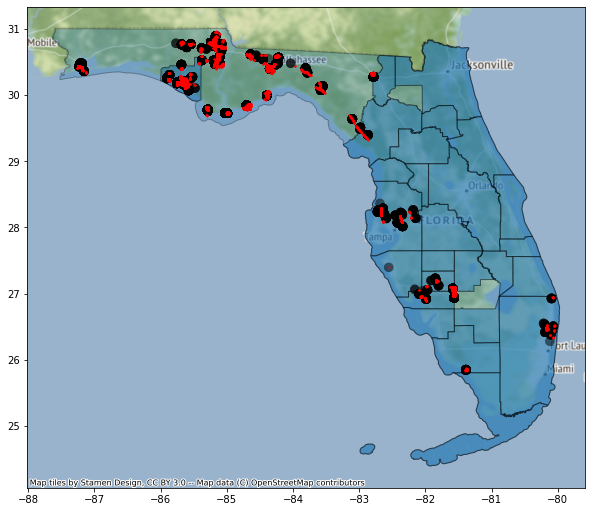

Total images:  9434
                                                       0
Miami-Fort Lauderdale-Pompano Beach, FL Metro Area    92
NaN                                                 3999
Gainesville, FL Metro Area                            36
Panama City, FL Metro Area                          4616
Lake City, FL Micro Area                              38
Tampa-St. Petersburg-Clearwater, FL Metro Area       257
Punta Gorda, FL Metro Area                           176
Arcadia, FL Micro Area                               134
Naples-Marco Island, FL Metro Area                    47
Sebring-Avon Park, FL Metro Area                      34
North Port-Sarasota-Bradenton, FL Metro Area           5


(None, None, None)

In [23]:
print('\n2018: ')
state_plotter('FL', image_metadata_gdf, '2018', True)

In [24]:
months_with_images('FL', image_metadata_gdf, '2018') #returns the number of images taken in FL in 2018

{'August': 328, 'September': 47, 'October': 11491, 'February': 93, 'November': 80, 'April': 79, 'March': 1, 'January': 7, 'December': 44, 'June': 24}



2018: 


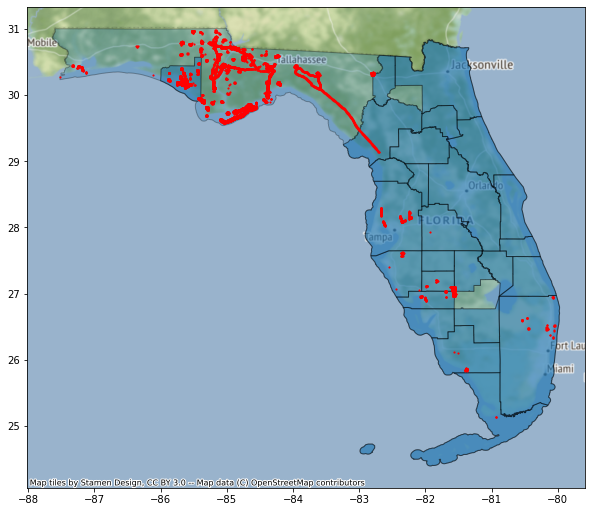

Total images:  12194
                                                       0
Key West, FL Micro Area                                3
Miami-Fort Lauderdale-Pompano Beach, FL Metro Area    61
NaN                                                 9562
Panama City, FL Metro Area                          1822
Gainesville, FL Metro Area                            77
Lake City, FL Micro Area                              38
Tampa-St. Petersburg-Clearwater, FL Metro Area       228
Punta Gorda, FL Metro Area                           178
Arcadia, FL Micro Area                               113
Naples-Marco Island, FL Metro Area                    49
Sebring-Avon Park, FL Metro Area                      34
North Port-Sarasota-Bradenton, FL Metro Area          28
Lakeland-Winter Haven, FL Metro Area                   1

OCTOBER 2018: 


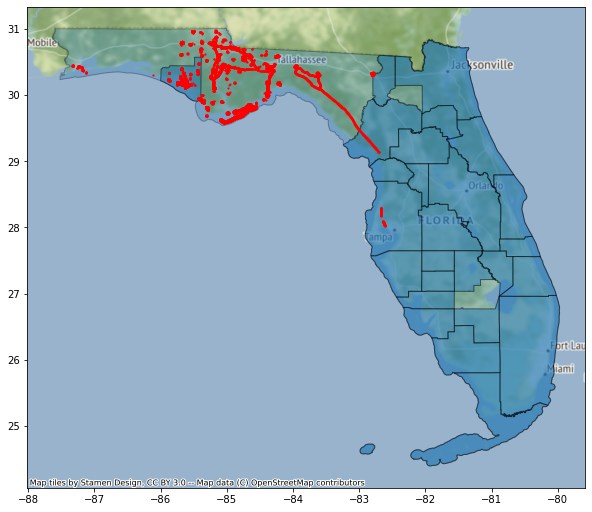

Total images:  11491
                                                   0
NaN                                             9464
Panama City, FL Metro Area                      1822
Gainesville, FL Metro Area                        77
Lake City, FL Micro Area                          38
Tampa-St. Petersburg-Clearwater, FL Metro Area    90


(None, None, None)

In [25]:
print('\n2018: ')
state_plotter('FL', image_metadata_gdf, '2018', False)
print('\nOCTOBER 2018: ')
state_plotter('FL', image_metadata_gdf, '2018-10', False)
#black circles represent the given buffer radius for the airports
#red dots are points for disaster images

In [26]:
months_with_images('FL', human_labeled_floods, '2018')

{'October': 154, 'September': 1, 'August': 5, 'November': 1, 'April': 1}



2018: 


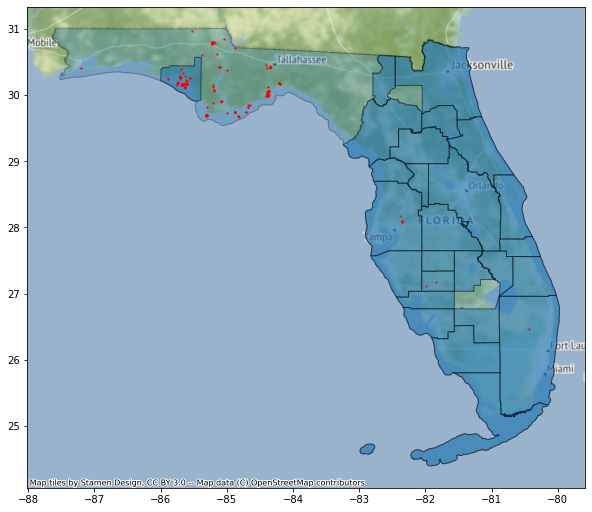

Total images:  162
                                                      0
NaN                                                 103
Panama City, FL Metro Area                           51
Miami-Fort Lauderdale-Pompano Beach, FL Metro Area    1
Tampa-St. Petersburg-Clearwater, FL Metro Area        5
Arcadia, FL Micro Area                                2

OCTOBER 2018: 


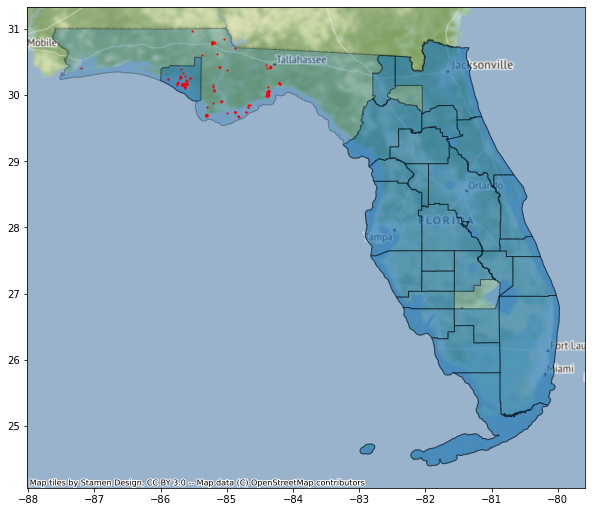

Total images:  154
                              0
NaN                         103
Panama City, FL Metro Area   51


(None, None, None)

In [27]:
print('\n2018: ')
state_plotter('FL', human_labeled_floods, '2018', False)
print('\nOCTOBER 2018: ')
state_plotter('FL', human_labeled_floods, '2018-10', False) # returns only images taken in October 2018

In [28]:
months_with_images('GA', image_metadata_gdf, '2018')

{'July': 53, 'October': 1881, 'March': 14, 'May': 7, 'June': 6, 'April': 49, 'September': 9}



2018: 


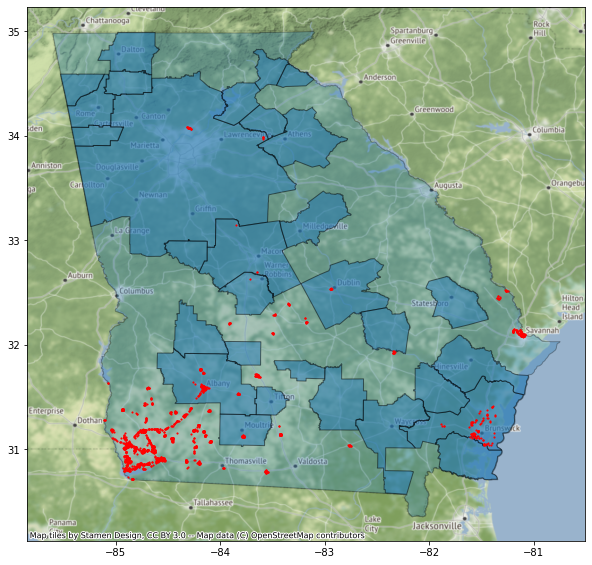

Total images:  2019
                                                    0
Atlanta-Sandy Springs-Alpharetta, GA Metro Area    22
NaN                                              1723
Warner Robins, GA Metro Area                        1
Albany, GA Metro Area                             138
Macon-Bibb County, GA Metro Area                    3
Dublin, GA Micro Area                              10
Moultrie, GA Micro Area                            21
Vidalia, GA Micro Area                              2
Brunswick, GA Metro Area                           95
St. Marys, GA Micro Area                            4

OCTOBER 2018: 


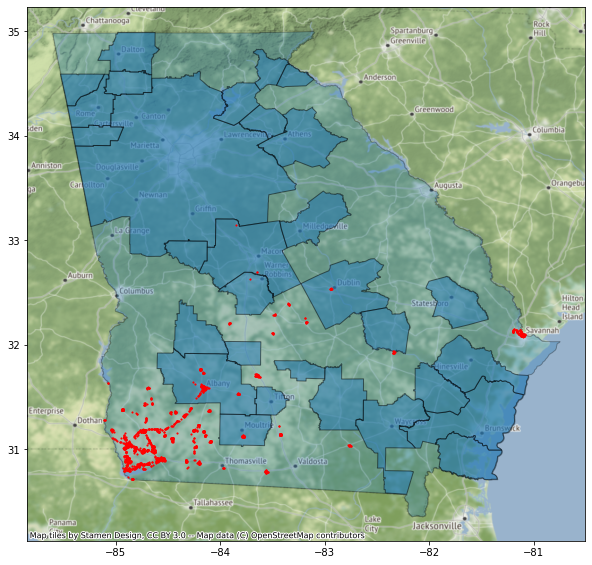

Total images:  1881
                                     0
NaN                               1706
Warner Robins, GA Metro Area         1
Albany, GA Metro Area              138
Macon-Bibb County, GA Metro Area     3
Dublin, GA Micro Area               10
Moultrie, GA Micro Area             21
Vidalia, GA Micro Area               2


(None, None, None)

In [29]:
print('\n2018: ')
state_plotter('GA', image_metadata_gdf, '2018', False)
print('\nOCTOBER 2018: ')
state_plotter('GA', image_metadata_gdf, '2018-10', False)

In [30]:
months_with_images('GA', human_labeled_floods, '2018')

{'October': 15, 'April': 3}


2018: 


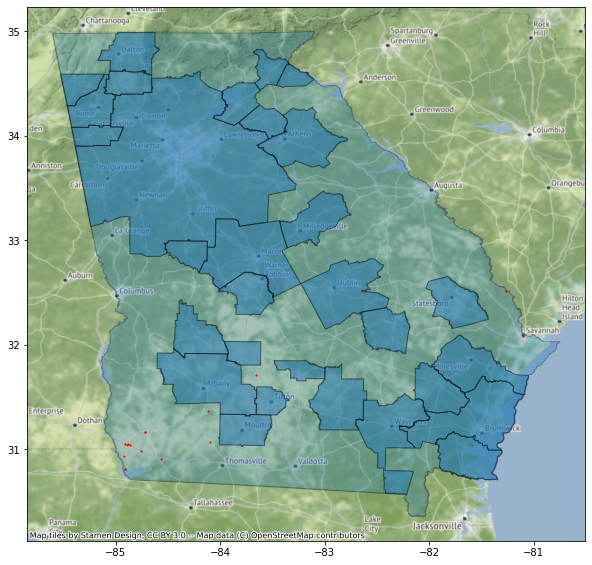

Total images:  18
      0
NaN  18

OCTOBER 2018: 


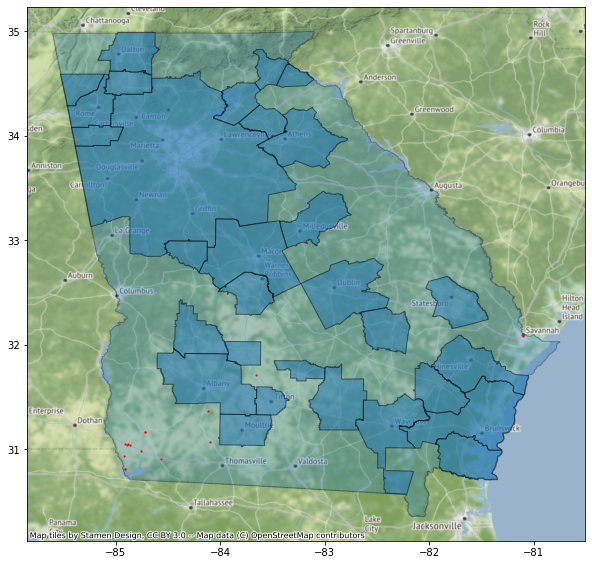

Total images:  15
      0
NaN  15


(None, None, None)

In [31]:
print('2018: ')
state_plotter('GA', human_labeled_floods, '2018', False)
print('\nOCTOBER 2018: ')
state_plotter('GA', human_labeled_floods, '2018-10', False)

# Hurricane Florence:
- HIT CAROLINAS DIRECTLY ALONG COAST LINE (AUGUST 31, 2018-SEPTEMBER 18TH, 2018)
- MAKES LANDFALL IN NC ON SEPTEMBER 14TH
- PUSHES WESTWARD THROUGH THE CAROLINAS AND INTO GEORGIA


In [32]:
months_with_images('NC', image_metadata_gdf, '2018')

{'May': 43, 'July': 501, 'September': 2948, 'January': 376, 'November': 383, 'June': 64, 'October': 146, 'December': 106, 'August': 2, 'February': 64, 'March': 77, 'April': 14}


2018: 


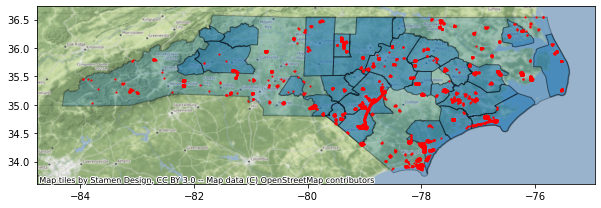

Total images:  4724
                                            0
NaN                                      1691
Albemarle, NC Micro Area                    7
Fayetteville, NC Metro Area               375
Lumberton, NC Micro Area                  380
Burlington, NC Metro Area                 176
Wilmington, NC Metro Area                 503
New Bern, NC Metro Area                   187
Morehead City, NC Micro Area              249
Washington, NC Micro Area                 165
Greenville, NC Metro Area                  40
Elizabeth City, NC Micro Area              63
Kill Devil Hills, NC Micro Area            91
Laurinburg, NC Micro Area                  85
Kinston, NC Micro Area                     71
Greensboro-High Point, NC Metro Area       30
Goldsboro, NC Metro Area                  122
Wilson, NC Micro Area                      28
Rocky Mount, NC Metro Area                 67
Pinehurst-Southern Pines, NC Micro Area    26
Rockingham, NC Micro Area                  32
Jacksonville, 

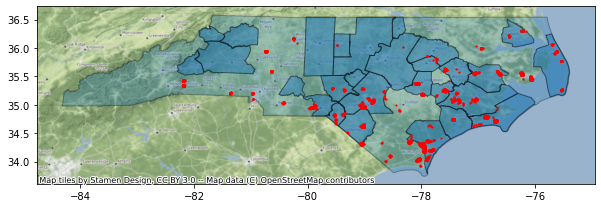

Total images:  2948
                                            0
Fayetteville, NC Metro Area               209
Lumberton, NC Micro Area                  111
NaN                                      1094
Burlington, NC Metro Area                   4
Wilmington, NC Metro Area                 477
New Bern, NC Metro Area                   164
Morehead City, NC Micro Area              203
Washington, NC Micro Area                 125
Greenville, NC Metro Area                  40
Elizabeth City, NC Micro Area              50
Kill Devil Hills, NC Micro Area            91
Laurinburg, NC Micro Area                  63
Kinston, NC Micro Area                     71
Goldsboro, NC Metro Area                  119
Wilson, NC Micro Area                       5
Rocky Mount, NC Metro Area                 12
Pinehurst-Southern Pines, NC Micro Area    26
Rockingham, NC Micro Area                  19
Jacksonville, NC Metro Area                63
Raleigh-Cary, NC Metro Area                 2

OCTOBER 2018:

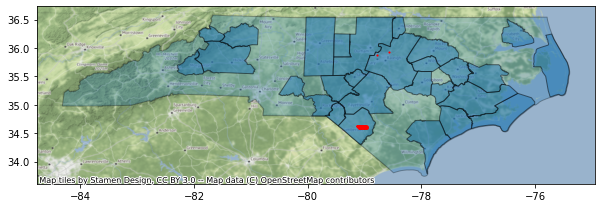

Total images:  146
                               0
Lumberton, NC Micro Area     144
Raleigh-Cary, NC Metro Area    2

NOVEMBER 2018: 


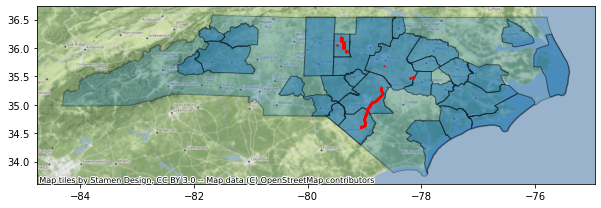

Total images:  383
                               0
Burlington, NC Metro Area    157
Raleigh-Cary, NC Metro Area   11
Lumberton, NC Micro Area     116
Fayetteville, NC Metro Area   99

DECEMBER 2018: 


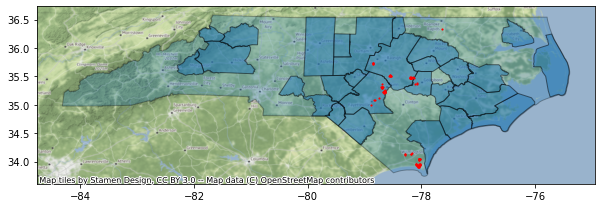

Total images:  106
                              0
Fayetteville, NC Metro Area  33
Raleigh-Cary, NC Metro Area  27
NaN                          43
Goldsboro, NC Metro Area      3


(None, None, None)

In [33]:
print('2018: ')
state_plotter('NC', image_metadata_gdf, '2018', False)
print('\nSEPTEMBER 2018: ')
state_plotter('NC', image_metadata_gdf, '2018-09', False)
print('\nOCTOBER 2018: ')
state_plotter('NC', image_metadata_gdf, '2018-10', False)
print('\nNOVEMBER 2018: ')
state_plotter('NC', image_metadata_gdf, '2018-11', False)
print('\nDECEMBER 2018: ')
state_plotter('NC', image_metadata_gdf, '2018-12', False)

In [34]:
months_with_images('NC', human_labeled_floods, '2018')

{'September': 421, 'November': 43, 'December': 41, 'October': 15, 'May': 2, 'July': 7, 'June': 6}


2018: 


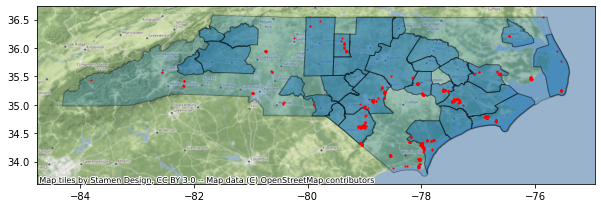

Total images:  535
                                        0
NaN                                   132
Morehead City, NC Micro Area           41
Burlington, NC Metro Area              31
Washington, NC Micro Area              19
Fayetteville, NC Metro Area            58
Lumberton, NC Micro Area               66
New Bern, NC Metro Area                45
Kinston, NC Micro Area                 28
Goldsboro, NC Metro Area               27
Wilmington, NC Metro Area              68
Rockingham, NC Micro Area               1
Raleigh-Cary, NC Metro Area             3
Kill Devil Hills, NC Micro Area        10
Elizabeth City, NC Micro Area           3
Greensboro-High Point, NC Metro Area    3

SEPTEMBER 2018: 


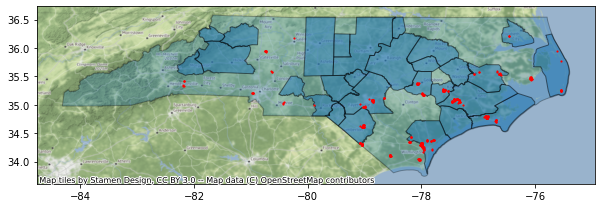

Total images:  421
                                  0
NaN                              99
Morehead City, NC Micro Area     41
Washington, NC Micro Area        19
Lumberton, NC Micro Area         45
New Bern, NC Metro Area          45
Kinston, NC Micro Area           28
Goldsboro, NC Metro Area         27
Fayetteville, NC Metro Area      35
Wilmington, NC Metro Area        68
Rockingham, NC Micro Area         1
Kill Devil Hills, NC Micro Area  10
Elizabeth City, NC Micro Area     3

OCTOBER 2018: 


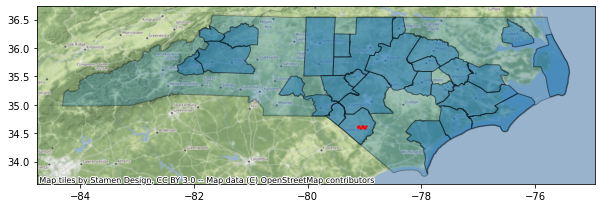

Total images:  15
                           0
Lumberton, NC Micro Area  15

NOVEMBER 2018: 


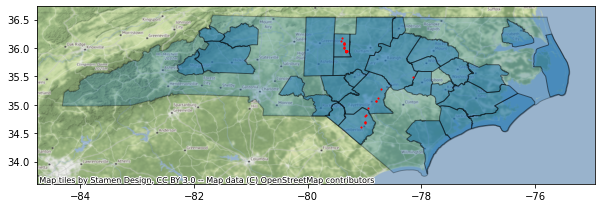

Total images:  43
                              0
Burlington, NC Metro Area    31
Fayetteville, NC Metro Area   5
Lumberton, NC Micro Area      6
Raleigh-Cary, NC Metro Area   1

DECEMBER 2018: 


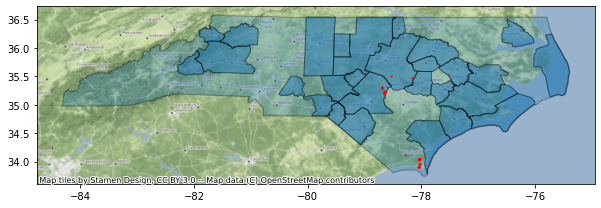

Total images:  41
                              0
NaN                          21
Fayetteville, NC Metro Area  18
Raleigh-Cary, NC Metro Area   2


(None, None, None)

In [35]:
print('2018: ')
state_plotter('NC', human_labeled_floods, '2018', False)
print('\nSEPTEMBER 2018: ')
state_plotter('NC', human_labeled_floods, '2018-09', False)
print('\nOCTOBER 2018: ')
state_plotter('NC', human_labeled_floods, '2018-10', False)
print('\nNOVEMBER 2018: ')
state_plotter('NC', human_labeled_floods, '2018-11', False)
print('\nDECEMBER 2018: ')
state_plotter('NC', human_labeled_floods, '2018-12', False)

In [36]:
months_with_images('SC', image_metadata_gdf, '2018')

{'September': 6505, 'October': 1257, 'April': 63, 'July': 151, 'June': 8, 'May': 2}


2018: 


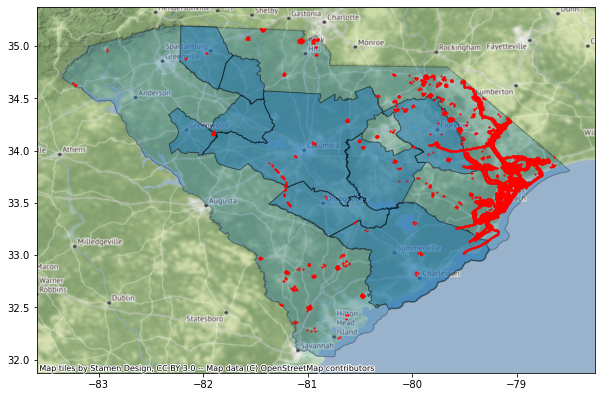

Total images:  7986
                                               0
NaN                                         7424
Florence, SC Metro Area                      351
Sumter, SC Metro Area                         31
Columbia, SC Metro Area                       53
Charleston-North Charleston, SC Metro Area    80
Orangeburg, SC Micro Area                     17
Spartanburg, SC Metro Area                     4
Newberry, SC Micro Area                       14
Greenwood, SC Micro Area                      12


(None, None, None)

In [37]:
print('2018: ')
state_plotter('SC', image_metadata_gdf, '2018', False)

In [38]:
months_with_images('SC', human_labeled_floods, '2018')

{'October': 534, 'September': 1623, 'July': 6, 'April': 3}


2018: 


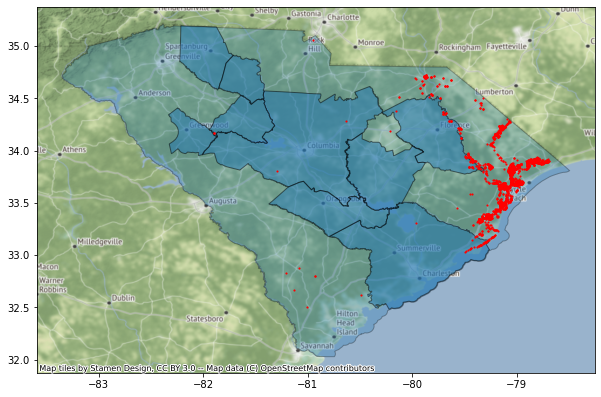

Total images:  2166
                                               0
NaN                                         2065
Florence, SC Metro Area                       59
Charleston-North Charleston, SC Metro Area    37
Newberry, SC Micro Area                        3
Columbia, SC Metro Area                        2

SEPTEMBER 2018: 


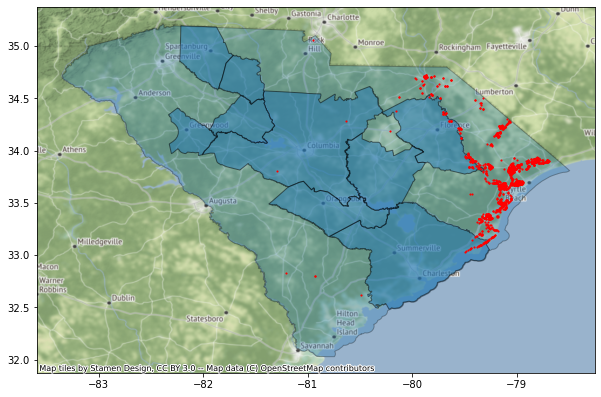

Total images:  1623
                                               0
NaN                                         1526
Florence, SC Metro Area                       59
Charleston-North Charleston, SC Metro Area    36
Columbia, SC Metro Area                        2

OCTOBER 2018: 


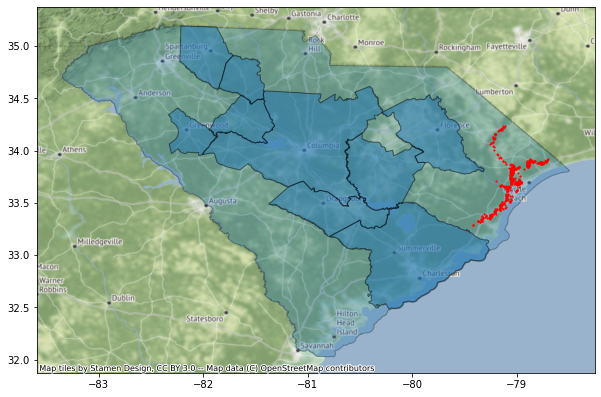

Total images:  534
       0
NaN  534


(None, None, None)

In [39]:
print('2018: ')
state_plotter('SC', human_labeled_floods, '2018', False)
print('\nSEPTEMBER 2018: ')
state_plotter('SC', human_labeled_floods, '2018-09', False)
print('\nOCTOBER 2018: ')
state_plotter('SC', human_labeled_floods, '2018-10', False)

In [40]:
months_with_images('FL', image_metadata_gdf, '2018')

{'August': 328, 'September': 47, 'October': 11491, 'February': 93, 'November': 80, 'April': 79, 'March': 1, 'January': 7, 'December': 44, 'June': 24}


2018: 


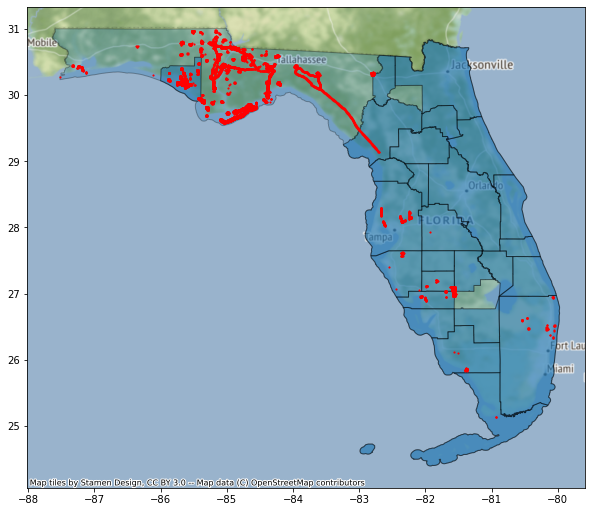

Total images:  12194
                                                       0
Key West, FL Micro Area                                3
Miami-Fort Lauderdale-Pompano Beach, FL Metro Area    61
NaN                                                 9562
Panama City, FL Metro Area                          1822
Gainesville, FL Metro Area                            77
Lake City, FL Micro Area                              38
Tampa-St. Petersburg-Clearwater, FL Metro Area       228
Punta Gorda, FL Metro Area                           178
Arcadia, FL Micro Area                               113
Naples-Marco Island, FL Metro Area                    49
Sebring-Avon Park, FL Metro Area                      34
North Port-Sarasota-Bradenton, FL Metro Area          28
Lakeland-Winter Haven, FL Metro Area                   1

AUGUST 2018: 


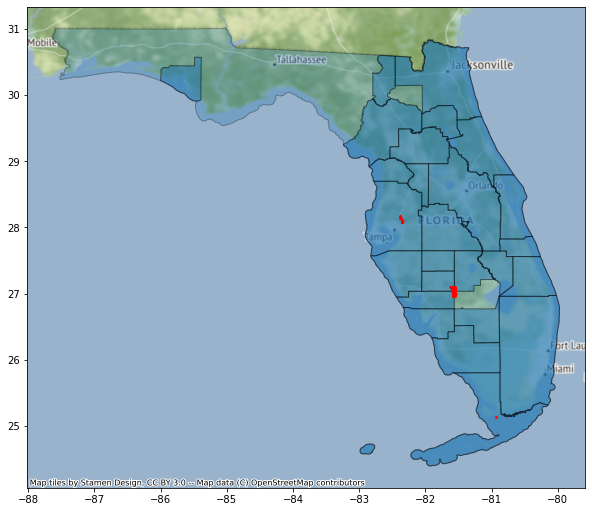

Total images:  328
                                                  0
Key West, FL Micro Area                           3
Tampa-St. Petersburg-Clearwater, FL Metro Area   66
Sebring-Avon Park, FL Metro Area                 34
Arcadia, FL Micro Area                           82
Punta Gorda, FL Metro Area                      111
NaN                                              32

SEPTEMBER 2018: 


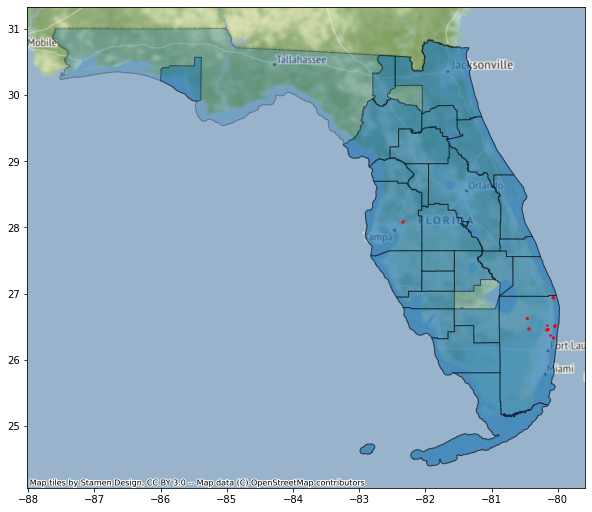

Total images:  47
                                                     0
Miami-Fort Lauderdale-Pompano Beach, FL Metro Area  42
Tampa-St. Petersburg-Clearwater, FL Metro Area       5

OCTOBER 2018: 


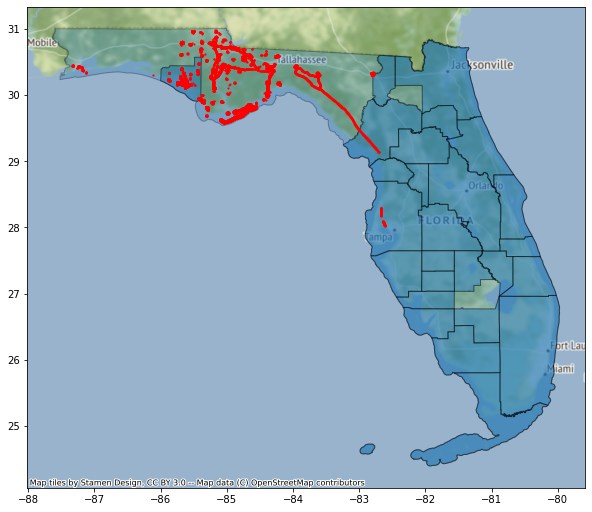

Total images:  11491
                                                   0
NaN                                             9464
Panama City, FL Metro Area                      1822
Gainesville, FL Metro Area                        77
Lake City, FL Micro Area                          38
Tampa-St. Petersburg-Clearwater, FL Metro Area    90

NOVEMBER 2018: 


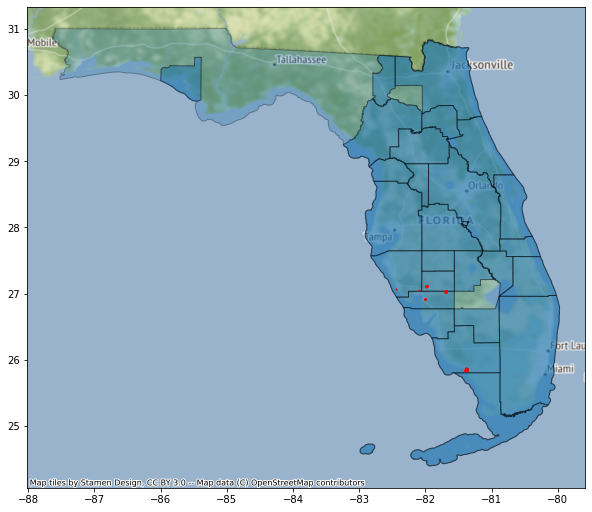

Total images:  80
                                               0
Punta Gorda, FL Metro Area                    14
Arcadia, FL Micro Area                        17
Naples-Marco Island, FL Metro Area            47
North Port-Sarasota-Bradenton, FL Metro Area   2

DECEMBER 2018: 


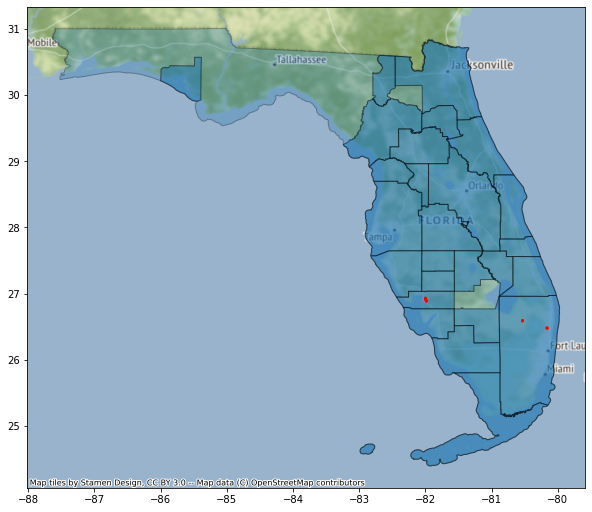

Total images:  44
                                                     0
Miami-Fort Lauderdale-Pompano Beach, FL Metro Area  15
Punta Gorda, FL Metro Area                          29


(None, None, None)

In [41]:
print('2018: ')
state_plotter('FL', image_metadata_gdf, '2018', False)
print('\nAUGUST 2018: ')
state_plotter('FL', image_metadata_gdf, '2018-08', False)
print('\nSEPTEMBER 2018: ')
state_plotter('FL', image_metadata_gdf, '2018-09', False)
print('\nOCTOBER 2018: ')
state_plotter('FL', image_metadata_gdf, '2018-10', False)
print('\nNOVEMBER 2018: ')
state_plotter('FL', image_metadata_gdf, '2018-11', False)
print('\nDECEMBER 2018: ')
state_plotter('FL', image_metadata_gdf, '2018-12', False)

In [42]:
months_with_images('FL', human_labeled_floods, '2018')

{'October': 154, 'September': 1, 'August': 5, 'November': 1, 'April': 1}


2018: 


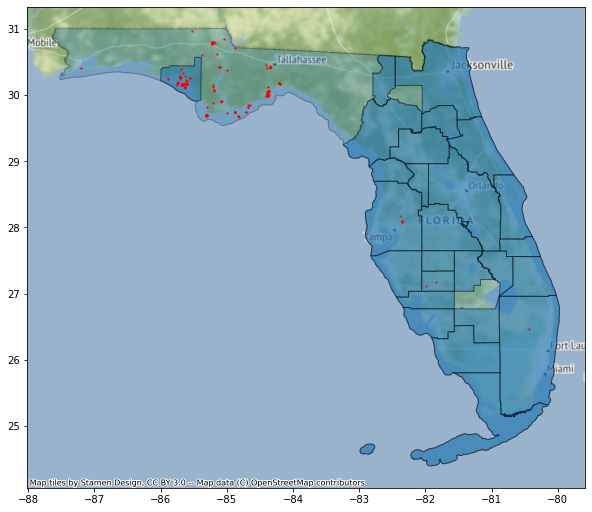

Total images:  162
                                                      0
NaN                                                 103
Panama City, FL Metro Area                           51
Miami-Fort Lauderdale-Pompano Beach, FL Metro Area    1
Tampa-St. Petersburg-Clearwater, FL Metro Area        5
Arcadia, FL Micro Area                                2

OCTOBER 2018: 


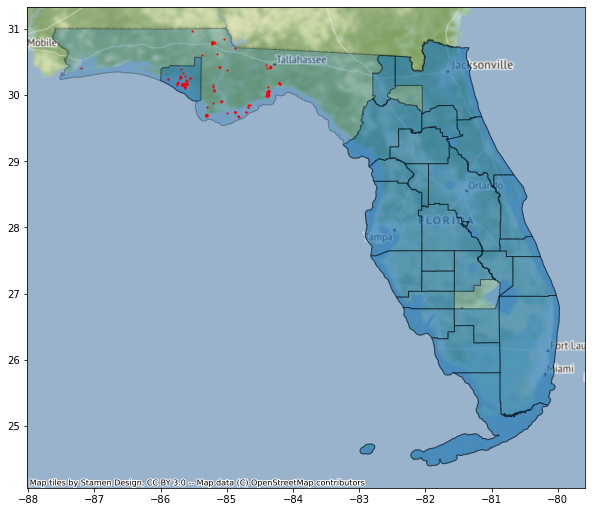

Total images:  154
                              0
NaN                         103
Panama City, FL Metro Area   51

NOVEMBER 2018: 


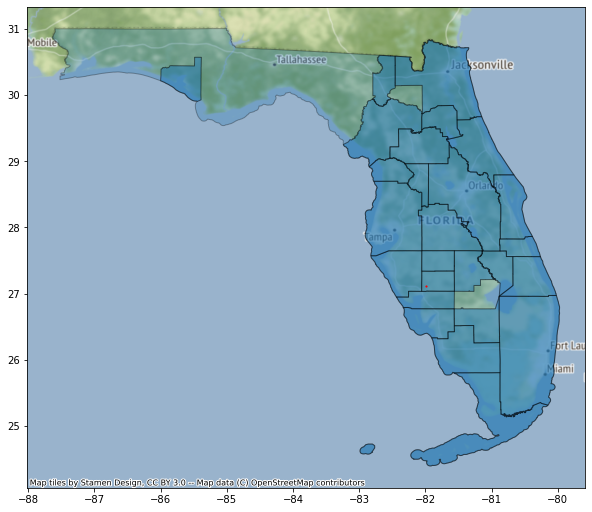

Total images:  1
                        0
Arcadia, FL Micro Area  1


(None, None, None)

In [43]:
print('2018: ')
state_plotter('FL', human_labeled_floods, '2018', False)
print('\nOCTOBER 2018: ')
state_plotter('FL', human_labeled_floods, '2018-10', False)
print('\nNOVEMBER 2018: ')
state_plotter('FL', human_labeled_floods, '2018-11', False)